Initial Data Overview:
                   TOID pollutant emissions-units  Road-Car-Petrol-2019  \
0  osgb4000000027865913       nox     tonnes/year              1.590568   
1  osgb4000000027865914       nox     tonnes/year              1.565236   
2  osgb4000000027865915       nox     tonnes/year              1.031740   
3  osgb4000000027865916       nox     tonnes/year              1.146019   
4  osgb4000000027865917       nox     tonnes/year              0.686157   

   Road-Car-Diesel-2019  Road-Car-Electric-2019  Road-PHV-Petrol-2019  \
0              6.993015                     0.0              0.030372   
1              7.108021                     0.0              0.034120   
2             10.018715                     0.0              0.079560   
3             11.792383                     0.0              0.075438   
4              6.986898                     0.0              0.044834   

   Road-PHV-Diesel-2019  Road-PHV-Electric-2019  Road-LGV-Petrol-2019  \
0             

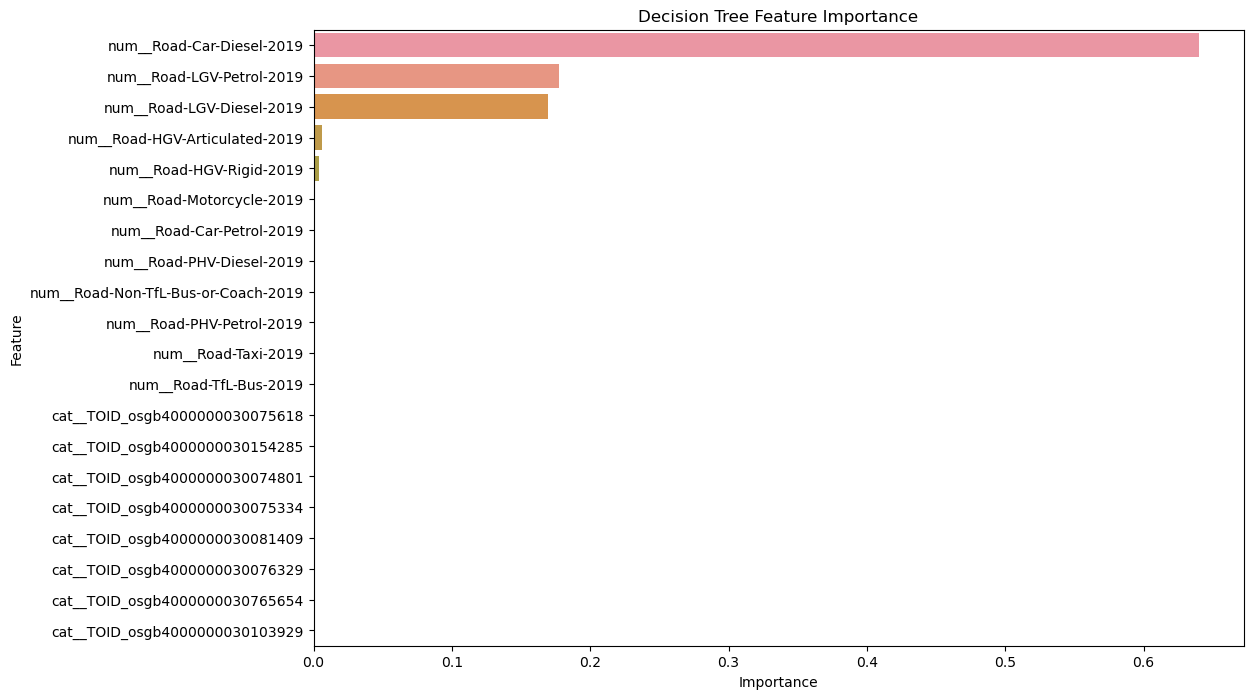


Training XGBoost...


C:\Users\jadoo\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBoost Evaluation Results:
Mean Squared Error: 10919.067452409168
Mean Absolute Error: 3.4799396127115783
R2 Score: 0.6470254653044247
Predictions saved to XGBoost_predictions2019_with_pollutant_names.csv


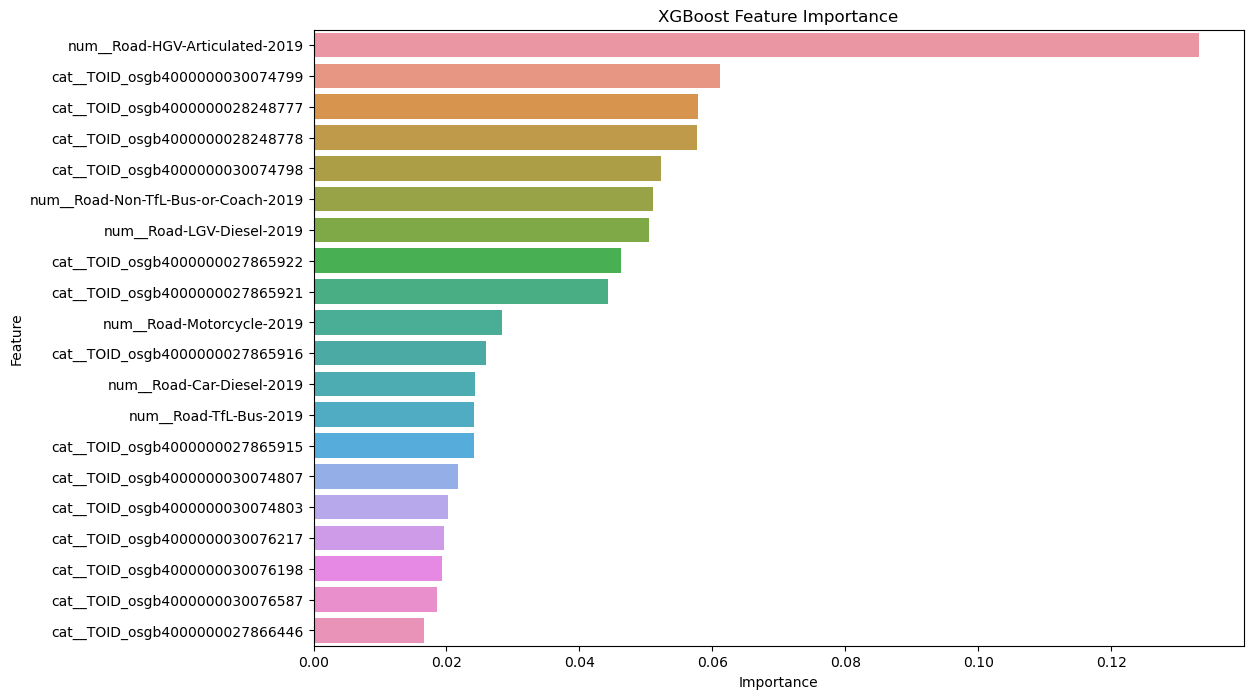


Model Performance Comparison:
                        mse      mae        r2
Decision Tree    419.994542  1.46637  0.986423
XGBoost        10919.067452  3.47994  0.647025


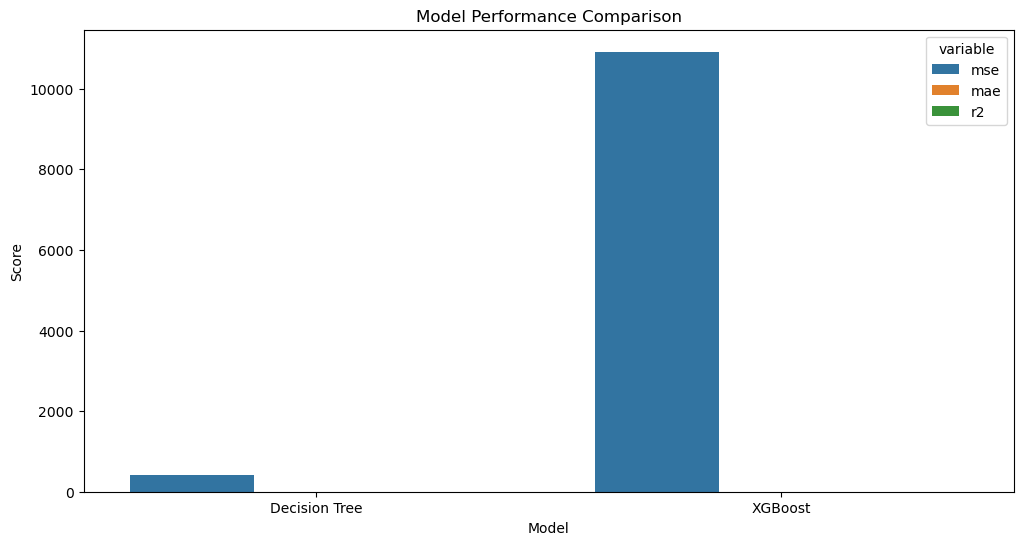

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load and Inspect the Data
data = pd.read_excel(r"D:\MSc AI\Dissertation\New data\Copy of combined_filtered_excel_file.xlsx")  # Update with the correct file path
print("Initial Data Overview:")
print(data.head())

# Step 2: Preprocessing
print("\nMissing Values Before Processing:")
print(data.isnull().sum())

# Fill missing values: categorical columns with mode, numerical with mean
for column in data.columns:
    if data[column].dtype == 'object':
        data[column].fillna(data[column].mode()[0], inplace=True)
    else:
        data[column].fillna(data[column].mean(), inplace=True)

print("\nMissing Values After Processing:")
print(data.isnull().sum())

# Step 3: Define Features and Target
X = data.drop(columns=['Road-Total-2025'])  # Target column
y = data['Road-Total-2025']

# Define categorical and numerical columns
categorical_features = ['TOID', 'pollutant', 'emissions-units']
numerical_features = [col for col in X.columns if col not in categorical_features]

# Column Transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 4: Preprocess Data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Step 5: Define Models with Efficient Hyperparameters
models = {
    'Decision Tree': DecisionTreeRegressor(random_state=42, max_depth=10),  # Set max_depth to 10 for speed
    'XGBoost': XGBRegressor(
        random_state=42,
        objective='reg:squarederror',
        n_estimators=100,  # Reduced number of boosting rounds
        max_depth=6,  # Smaller depth to reduce complexity
        learning_rate=0.1,
        n_jobs=-1,
        verbosity=0
    )
}

# Step 6: Train, Evaluate, and Save Predictions
results = {}

for model_name, model in models.items():
    print(f"\nTraining {model_name}...")

    # Apply early stopping to XGBoost to speed up training if applicable
    if model_name == 'XGBoost':
        model.fit(
            X_train_processed, y_train,
            eval_set=[(X_test_processed, y_test)],
            early_stopping_rounds=10,  # Stops training if no improvement
            verbose=False
        )
    else:
        model.fit(X_train_processed, y_train)

    predictions = model.predict(X_test_processed)

    # Evaluation Metrics
    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)

    print(f"{model_name} Evaluation Results:")
    print(f"Mean Squared Error: {mse}")
    print(f"Mean Absolute Error: {mae}")
    print(f"R2 Score: {r2}")

    # Save results
    results[model_name] = {'mse': mse, 'mae': mae, 'r2': r2}

    # Save predictions to a CSV file
    results_with_pollutant = X_test.copy()
    results_with_pollutant['Actual_Total'] = y_test
    results_with_pollutant['Predicted_Total'] = predictions

    output_filename = f'{model_name}_predictions2019_with_pollutant_names.csv'
    results_with_pollutant.to_csv(output_filename, index=False)
    print(f"Predictions saved to {output_filename}")

    # Plot Feature Importance
    if model_name == 'XGBoost':
        # Feature importance from XGBoost
        importance = model.feature_importances_
        feature_names = preprocessor.get_feature_names_out()
    else:
        # Feature importance from Decision Tree
        importance = model.feature_importances_
        feature_names = preprocessor.get_feature_names_out()

    # Plotting feature importance
    plt.figure(figsize=(12, 8))
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance
    }).sort_values(by='Importance', ascending=False)

    sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))  # Plot top 20 features
    plt.title(f'{model_name} Feature Importance')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()

# Step 7: Compare Model Performance
print("\nModel Performance Comparison:")
performance_df = pd.DataFrame(results).T
print(performance_df)

# Visualization of Model Performance
plt.figure(figsize=(12, 6))
sns.barplot(data=performance_df.reset_index().melt(id_vars='index'), x='index', y='value', hue='variable')
plt.title('Model Performance Comparison')
plt.xlabel('Model')
plt.ylabel('Score')
plt.show()


Initial Data Overview:
                   TOID pollutant emissions-units  Road-Car-Petrol-2019  \
0  osgb4000000027865913       nox     tonnes/year              1.590568   
1  osgb4000000027865914       nox     tonnes/year              1.565236   
2  osgb4000000027865915       nox     tonnes/year              1.031740   
3  osgb4000000027865916       nox     tonnes/year              1.146019   
4  osgb4000000027865917       nox     tonnes/year              0.686157   

   Road-Car-Diesel-2019  Road-Car-Electric-2019  Road-PHV-Petrol-2019  \
0              6.993015                     0.0              0.030372   
1              7.108021                     0.0              0.034120   
2             10.018715                     0.0              0.079560   
3             11.792383                     0.0              0.075438   
4              6.986898                     0.0              0.044834   

   Road-PHV-Diesel-2019  Road-PHV-Electric-2019  Road-LGV-Petrol-2019  \
0             

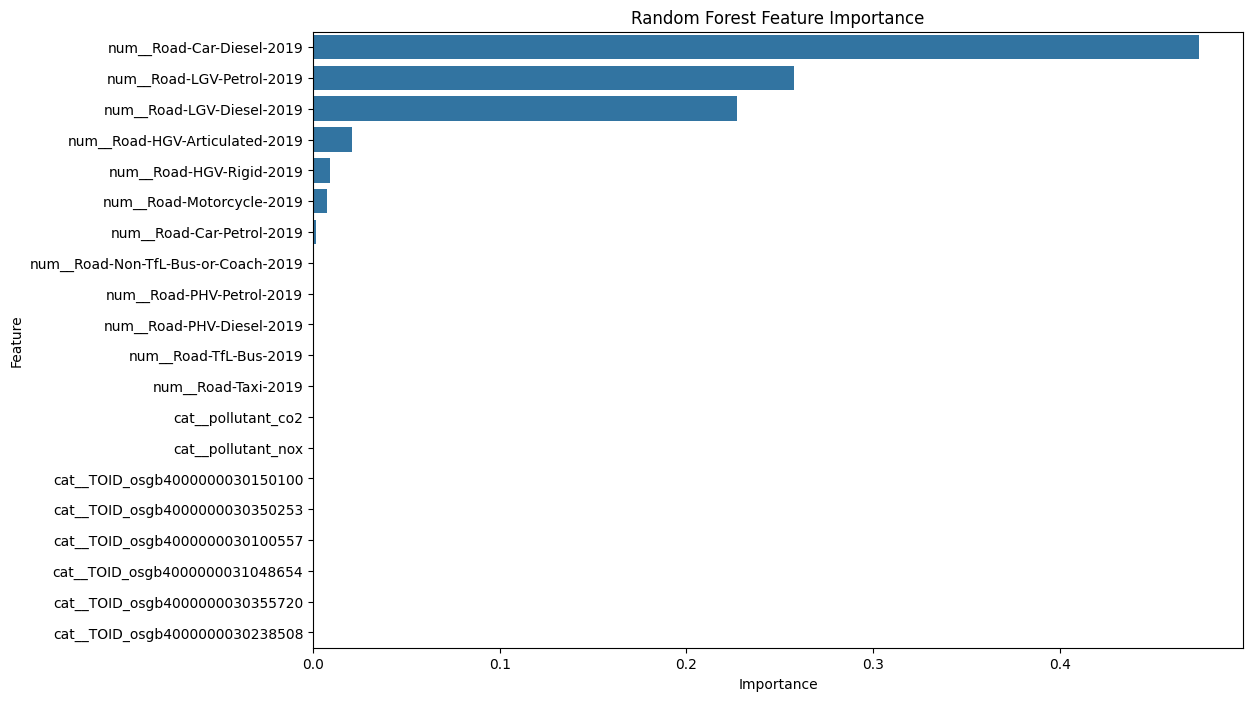


Model Performance Comparison:
                    mae         mse        r2
Random Forest  1.025461  187.598862  0.993936


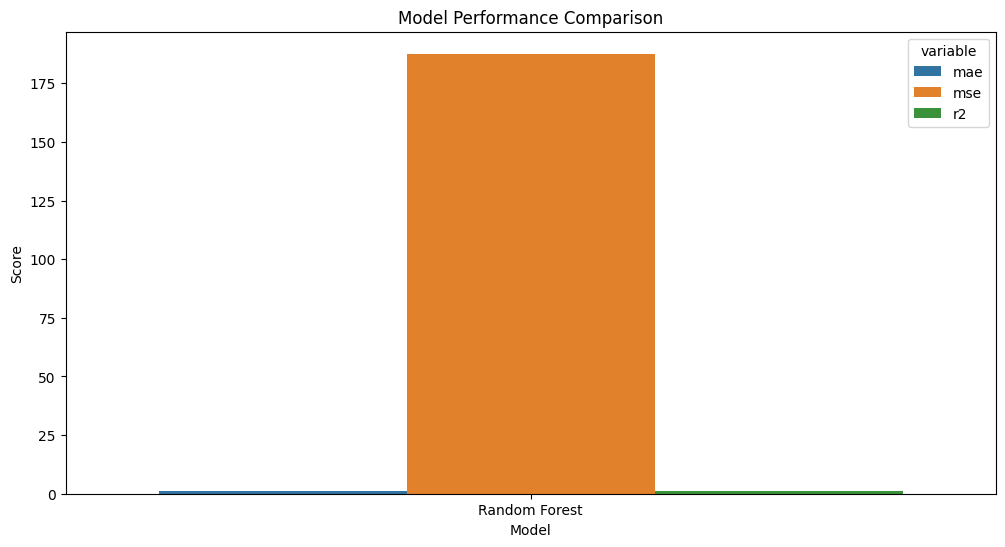

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load and Inspect the Data
data = pd.read_excel("/content/drive/MyDrive/dissertation_data/Copy of combined_filtered_excel_file.xlsx")  # Update with the correct file path
print("Initial Data Overview:")
print(data.head())

# Step 2: Preprocessing
print("\nMissing Values Before Processing:")
print(data.isnull().sum())

# Fill missing values: categorical columns with mode, numerical with mean
for column in data.columns:
    if data[column].dtype == 'object':
        data[column].fillna(data[column].mode()[0], inplace=True)
    else:
        data[column].fillna(data[column].mean(), inplace=True)

print("\nMissing Values After Processing:")
print(data.isnull().sum())

# Step 3: Define Features and Target
X = data.drop(columns=['Road-Total-2025'])  # Target column
y = data['Road-Total-2025']

# Define categorical and numerical columns
categorical_features = ['TOID', 'pollutant', 'emissions-units']
numerical_features = [col for col in X.columns if col not in categorical_features]

# Column Transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 4: Preprocess Data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Step 5: Define and Train Random Forest Model
model = RandomForestRegressor(
    random_state=42,
    n_estimators=100,    # Keep number of trees manageable
    max_depth=10,        # Limit depth to reduce overfitting
    min_samples_split=5, # Require more samples for splitting to avoid overfitting
    min_samples_leaf=4,  # Ensure a minimum number of samples in leaf nodes
    n_jobs=-1            # Use all processors for training
)

print("\nTraining Random Forest Model...")
model.fit(X_train_processed, y_train)

# Step 6: Predict and Evaluate
predictions = model.predict(X_test_processed)

# Evaluation Metrics
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print("\nRandom Forest Evaluation Results:")
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R2 Score: {r2}")

# Save results
results = {'Random Forest': {'mse': mse, 'mae': mae, 'r2': r2}}

# Save predictions to a CSV file
results_with_pollutant = X_test.copy()
results_with_pollutant['Actual_Total'] = y_test
results_with_pollutant['Predicted_Total'] = predictions
output_filename = 'Random_Forest_predictions_with_pollutant_names.csv'
results_with_pollutant.to_csv(output_filename, index=False)
print(f"Predictions saved to {output_filename}")

# Plot Feature Importance for Random Forest
importance = model.feature_importances_
feature_names = preprocessor.get_feature_names_out()

# Plotting feature importance
plt.figure(figsize=(12, 8))
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))  # Plot top 20 features
plt.title('Random Forest Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Step 7: Compare Model Performance
print("\nModel Performance Comparison:")
performance_df = pd.DataFrame(results).T
print(performance_df)

# Visualization of Model Performance
plt.figure(figsize=(12, 6))
sns.barplot(data=performance_df.reset_index().melt(id_vars='index'), x='index', y='value', hue='variable')
plt.title('Model Performance Comparison')
plt.xlabel('Model')
plt.ylabel('Score')
plt.show()


Initial Data Overview:
                   TOID pollutant emissions-units  Road-Car-Petrol-2019  \
0  osgb4000000027865913       nox     tonnes/year              1.590568   
1  osgb4000000027865914       nox     tonnes/year              1.565236   
2  osgb4000000027865915       nox     tonnes/year              1.031740   
3  osgb4000000027865916       nox     tonnes/year              1.146019   
4  osgb4000000027865917       nox     tonnes/year              0.686157   

   Road-Car-Diesel-2019  Road-Car-Electric-2019  Road-PHV-Petrol-2019  \
0              6.993015                     0.0              0.030372   
1              7.108021                     0.0              0.034120   
2             10.018715                     0.0              0.079560   
3             11.792383                     0.0              0.075438   
4              6.986898                     0.0              0.044834   

   Road-PHV-Diesel-2019  Road-PHV-Electric-2019  Road-LGV-Petrol-2019  \
0             

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))



Training Best Neural Network Model...
Epoch 1/50
14298/14298 - 105s - 7ms/step - loss: 4320.5405 - mae: 13.2799 - val_loss: 418.4791 - val_mae: 1.4375 - learning_rate: 0.0010
Epoch 2/50
14298/14298 - 102s - 7ms/step - loss: 2727.3909 - mae: 4.5747 - val_loss: 626.3676 - val_mae: 2.9406 - learning_rate: 0.0010
Epoch 3/50
14298/14298 - 104s - 7ms/step - loss: 2254.7219 - mae: 4.7484 - val_loss: 477.0417 - val_mae: 3.0214 - learning_rate: 0.0010
Epoch 4/50
14298/14298 - 102s - 7ms/step - loss: 3067.2920 - mae: 4.6772 - val_loss: 473.3382 - val_mae: 3.0140 - learning_rate: 5.0000e-04
Epoch 5/50
14298/14298 - 140s - 10ms/step - loss: 2642.8149 - mae: 4.6097 - val_loss: 441.8705 - val_mae: 2.9897 - learning_rate: 5.0000e-04
Epoch 6/50
14298/14298 - 104s - 7ms/step - loss: 2571.0745 - mae: 4.4816 - val_loss: 342.5407 - val_mae: 2.8362 - learning_rate: 2.5000e-04
Epoch 7/50
14298/14298 - 140s - 10ms/step - loss: 2859.0303 - mae: 4.4835 - val_loss: 430.0517 - val_mae: 2.9733 - learning_rate: 2

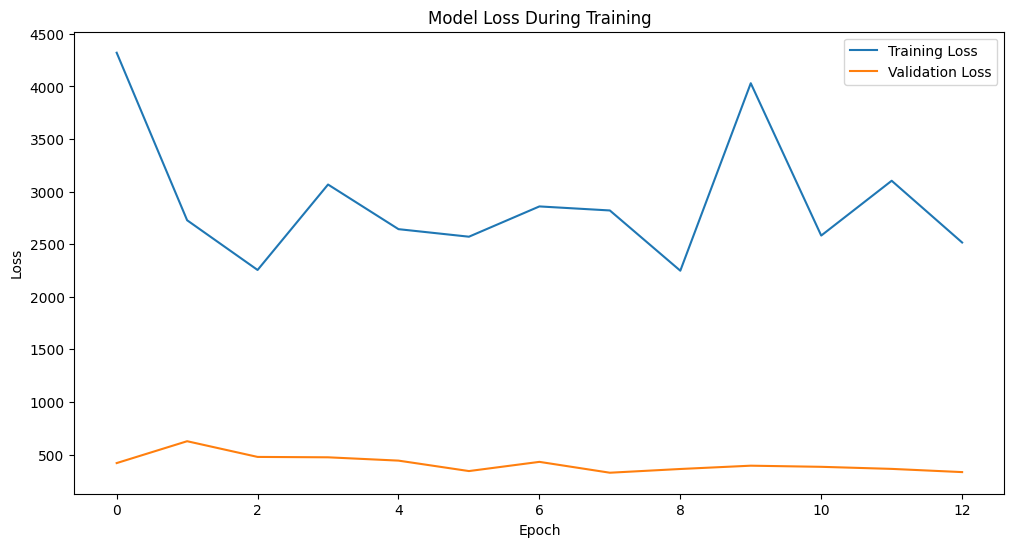

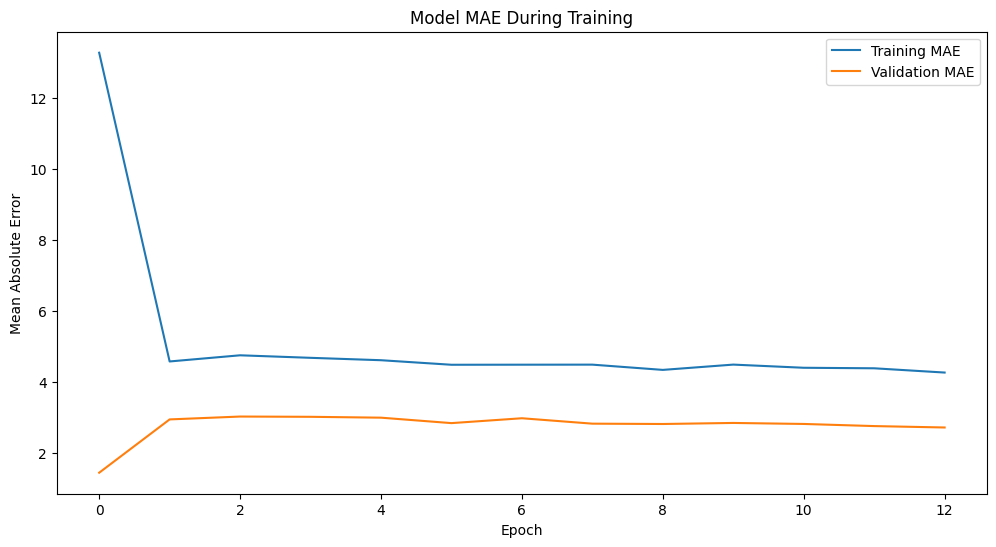

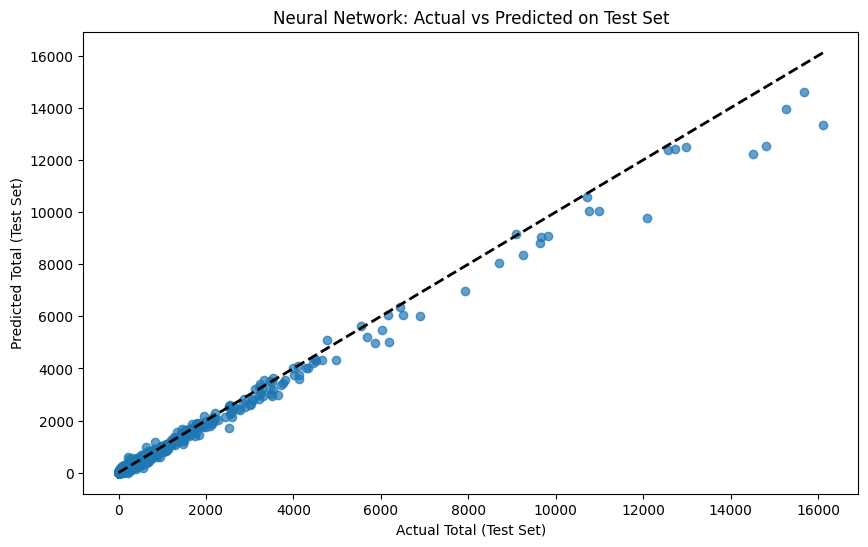


Predictions saved to Neural_Network_predictions_with_pollutant_names.csv
Evaluation metrics saved to Neural_Network_evaluation_metrics.csv
       Pollutant  Actual_Total  Predicted_Total
98524       pm10      0.000221         1.226252
446358     pm2.5      0.002918         1.226252
617263       co2      1.910705         3.728900
347743     pm2.5      0.000319         1.226252
249164      pm10      0.002619         1.226252
                Metric       Value
0   Mean Squared Error  397.552515
1  Mean Absolute Error    2.836669
2             R2 Score    0.987733


In [5]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt
from keras_tuner import RandomSearch

# Step 1: Load and Inspect the Data
data = pd.read_excel("/content/drive/MyDrive/dissertation_data/Copy of combined_filtered_excel_file.xlsx")
print("Initial Data Overview:")
print(data.head())
print(data.info())

# Step 2: Preprocessing
# Handle missing values
for column in data.columns:
    if data[column].dtype == 'object':  # Categorical columns
        data[column].fillna(data[column].mode()[0], inplace=True)
    else:  # Numerical columns
        data[column].fillna(data[column].mean(), inplace=True)

# Step 3: Define Features and Target
X = data.drop(columns=['Road-Total-2025'])  # Target column
y = data['Road-Total-2025']

# Preserve 'Pollutant' column for later use
pollutant_column = X['pollutant']

# Define categorical and numerical columns
categorical_features = ['TOID', 'pollutant', 'emissions-units']
numerical_features = [col for col in X.columns if col not in categorical_features]

# Step 4: Column Transformer and Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),          # Scale numerical features
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)  # One-hot encode categorical features
    ])

# Transform data
X_transformed = preprocessor.fit_transform(X)

# Split data into training and test sets
X_train, X_test, y_train, y_test, pollutant_train, pollutant_test = train_test_split(
    X_transformed, y, pollutant_column, test_size=0.2, random_state=42
)

# Step 5: Simplified model with Dropout for overfitting reduction
def build_model(hp):
    model = Sequential()
    # Single Hidden Layer with minimal units
    model.add(Dense(units=hp.Int('units', min_value=8, max_value=16, step=8), activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dropout(rate=0.3))  # Add dropout layer to reduce overfitting
    model.add(Dense(1))  # Regression output
    model.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', [1e-3, 1e-4])),
                  loss='mse', metrics=['mae'])
    return model

# Keras Tuner Random Search
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=3,  # Reduced number of trials
    executions_per_trial=1,
    directory='keras_tuner_dir',
    project_name='neural_network_tuning'
)

# Search for the best hyperparameters
tuner.search(X_train, y_train, epochs=10, validation_split=0.1, callbacks=[
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
], verbose=2)

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Callbacks for final training
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)
model_checkpoint = ModelCheckpoint('best_neural_model.keras', save_best_only=True, monitor='val_loss', mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Final Training with best hyperparameters on the training set
print("\nTraining Best Neural Network Model...")
history = best_model.fit(
    X_train, y_train,
    validation_split=0.1,  # Using a validation split to monitor for overfitting
    epochs=50,  # Keep epochs as 50
    batch_size=32,  # Adjust batch size for potentially faster convergence
    callbacks=[reduce_lr, model_checkpoint, early_stopping],
    verbose=2
)

# Load the best weights
best_model.load_weights('best_neural_model.keras')

# Step 6: Prediction and Evaluation on Test Set
test_predictions = best_model.predict(X_test).flatten()

# Evaluation Metrics on Test Set
test_mse = mean_squared_error(y_test, test_predictions)
test_mae = mean_absolute_error(y_test, test_predictions)
test_r2 = r2_score(y_test, test_predictions)

print("\nTest Set Evaluation Results:")
print(f"Test Mean Squared Error: {test_mse}")
print(f"Test Mean Absolute Error: {test_mae}")
print(f"Test R2 Score: {test_r2}")

# Step 7: Visualization of Training History
# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training & validation MAE values
plt.figure(figsize=(12, 6))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE During Training')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

# Plot Actual vs Predicted for Neural Network on Test Set
plt.figure(figsize=(10, 6))
plt.scatter(y_test, test_predictions, alpha=0.7)
plt.xlabel('Actual Total (Test Set)')
plt.ylabel('Predicted Total (Test Set)')
plt.title('Neural Network: Actual vs Predicted on Test Set')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.show()

# Step 8: Save Predictions to CSV
# Add the 'Pollutant' column back to the test set to include it in the results
results_with_pollutant = pd.DataFrame({
    'Pollutant': pollutant_test,
    'Actual_Total': y_test,
    'Predicted_Total': test_predictions
})

# Save performance metrics in a dataframe for saving to CSV
evaluation_metrics = {
    'Metric': ['Mean Squared Error', 'Mean Absolute Error', 'R2 Score'],
    'Value': [test_mse, test_mae, test_r2]
}

metrics_df = pd.DataFrame(evaluation_metrics)

# Save results to CSV
output_filename = 'Neural_Network_predictions_with_pollutant_names.csv'
results_with_pollutant.to_csv(output_filename, index=False)

# Save metrics to a separate CSV file
metrics_filename = 'Neural_Network_evaluation_metrics.csv'
metrics_df.to_csv(metrics_filename, index=False)

print(f"\nPredictions saved to {output_filename}")
print(f"Evaluation metrics saved to {metrics_filename}")
print(results_with_pollutant.head())
print(metrics_df)


In [ ]:
pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.3 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
